# MetroPT-3 Dataset

El **MetroPT-3 Dataset** es un conjunto de datos multivariado y temporal diseñado para tareas de mantenimiento predictivo, detección de anomalías y estimación de vida útil remanente (RUL) en compresores de unidades de producción de aire (APU) de trenes. Los datos se registraron entre febrero y agosto de 2020 a una frecuencia de 1Hz, proporcionando 15 características extraídas de sensores analógicos y digitales. Contiene información sin etiquetar, pero se acompañan reportes de fallas para evaluar modelos.

---

## Descripción de las columnas (atributos):

- **TP2 (bar):** Presión en el compresor.
- **TP3 (bar):** Presión generada en el panel neumático.
- **H1 (bar):** Presión causada por la caída al descargar el filtro separador ciclónico.
- **DV Pressure (bar):** Presión de descarga en secadores de aire (valor 0 indica operación bajo carga).
- **Reservoirs (bar):** Presión en los depósitos, debe aproximarse a TP3.
- **Motor Current (A):** Corriente de un motor trifásico:
  - `0A`: Apagado.
  - `4A`: Sin carga.
  - `7A`: Bajo carga.
  - `9A`: Encendido.
- **Oil Temperature (ºC):** Temperatura del aceite en el compresor.
- **COMP:** Señal eléctrica de la válvula de admisión de aire; indica estado apagado o sin carga.
- **DV Electric:** Señal eléctrica que controla la válvula de salida del compresor; activa bajo carga.
- **TOWERS:** Señal que identifica la torre activa para secado o drenaje de humedad:
  - **Inactiva:** Torre 1.
  - **Activa:** Torre 2.
- **MPG:** Señal para iniciar el compresor bajo carga si la presión cae por debajo de 8.2 bar.
- **LPS:** Señal que activa cuando la presión baja de 7 bar.
- **Pressure Switch:** Señal que detecta descargas en torres de secado de aire.
- **Oil Level:** Señal que detecta niveles de aceite bajos.
- **Caudal Impulse:** Pulso generado por el flujo de aire hacia los depósitos.

In [28]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

plt.style.use("ggplot")

# Lectura y descripción de datos
Leemos los datos y sacamos estadísticos básicos, así como porcentaje de nulos y alguna limpieza básica inicial.

In [29]:
# ----- Read data ----- #
csv_path = "MetroPT3(AirCompressor).csv"
data = pl.read_csv(csv_path)

# ----- Summarizing data ----- #
print(data.shape)
print(data.columns)
print(data.describe())
print(data.null_count())
for col, dtype in zip(data.columns, data.dtypes):
    print(f"Column: {col}, Type: {dtype}")
# ----- Cleaning data ----- #
# Columns that are not features
data = data.drop(pl.col(""))
print(len(data.columns))
print(data.describe())

(1516948, 17)
['', 'timestamp', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature', 'Motor_current', 'COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']
shape: (9, 18)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆           ┆ timestamp ┆ TP2       ┆ … ┆ LPS       ┆ Pressure_ ┆ Oil_level ┆ Caudal_i │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ switch    ┆ ---       ┆ mpulses  │
│ str       ┆ f64       ┆ str       ┆ f64       ┆   ┆ f64       ┆ ---       ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆ f64       ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 1.516948e ┆ 1516948   ┆ 1.516948e ┆ … ┆ 1.516948e ┆ 1.516948e ┆ 1.516948e ┆ 1.516948 │
│           ┆ 6         ┆           ┆ 6         ┆   ┆ 6         

- Tenemos más de un millón de observaciones correspondientes a distintos momentos en el tiempo que capturan datos de distintos sensores. Todas las variables son continuas a excepción del *timestamp*, que es la fecha de registro de cada valor en las variables.
- No hay nulos, por lo que no se requiere ningún tratamiento especial para ese tipo de casos.

# Transformaciones
- Inicialmente vamos a transformar la variable de *timestamp* en formato de tiempo para poder filtrarla bien y trabajar cómodamente con ella.

In [30]:
# Convert timestamp to Datetime
if data["timestamp"].dtype == pl.Utf8:
    data = data.with_columns(
        pl.col("timestamp").str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S")
    )
print(data["timestamp"])

shape: (1_516_948,)
Series: 'timestamp' [datetime[μs]]
[
	2020-02-01 00:00:00
	2020-02-01 00:00:10
	2020-02-01 00:00:19
	2020-02-01 00:00:29
	2020-02-01 00:00:39
	…
	2020-09-01 03:59:10
	2020-09-01 03:59:20
	2020-09-01 03:59:30
	2020-09-01 03:59:40
	2020-09-01 03:59:50
]


- Vamos a estandarizar los datos para poder visualizarlos y que las escalas no afecten demasiado a estas visualizaciones.
- No normalizamos por la desviación típica, queremos conservar la variación de los datos. No queremos que pierdan su relación original de escalas.

In [31]:
scaler = StandardScaler(with_std=False)

# We should not normalize timestamp
timestamp = data["timestamp"]

# Normalize the remaining columns
data_norm_array = scaler.fit_transform(data.select(pl.exclude("timestamp")).to_numpy())
data_norm = pl.DataFrame(data_norm_array, schema=data.select(pl.exclude("timestamp")).columns)

# Add the "timestamp" column back to the normalized data
data_norm = data_norm.with_columns(timestamp)

print(data_norm)

shape: (1_516_948, 16)
┌───────────┬───────────┬──────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ TP2       ┆ TP3       ┆ H1       ┆ DV_pressu ┆ … ┆ Pressure_ ┆ Oil_level ┆ Caudal_im ┆ timestamp │
│ ---       ┆ ---       ┆ ---      ┆ re        ┆   ┆ switch    ┆ ---       ┆ pulses    ┆ ---       │
│ f64       ┆ f64       ┆ f64      ┆ ---       ┆   ┆ ---       ┆ f64       ┆ ---       ┆ datetime[ │
│           ┆           ┆          ┆ f64       ┆   ┆ f64       ┆           ┆ f64       ┆ μs]       │
╞═══════════╪═══════════╪══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ -1.379826 ┆ 0.373389  ┆ 1.771845 ┆ -0.079956 ┆ … ┆ 0.008563  ┆ 0.095844  ┆ 0.062893  ┆ 2020-02-0 │
│           ┆           ┆          ┆           ┆   ┆           ┆           ┆           ┆ 1         │
│           ┆           ┆          ┆           ┆   ┆           ┆           ┆           ┆ 00:00:00  │
│ -1.381826 ┆ 0.363389  ┆ 1.763845 ┆ -0.077956 ┆ … ┆ 0.008563  ┆ 0.0

# Visualizaciones

- Comprobamos los rangos temporales en los que se mueven las variables.

In [32]:
max_time = data_norm.filter(pl.col("timestamp") == data_norm["timestamp"].max()).select(
    pl.col("timestamp")
)
min_time = data_norm.filter(pl.col("timestamp") == data_norm["timestamp"].min()).select(
    pl.col("timestamp")
)

print(max_time)
print(min_time)

shape: (1, 1)
┌─────────────────────┐
│ timestamp           │
│ ---                 │
│ datetime[μs]        │
╞═════════════════════╡
│ 2020-09-01 03:59:50 │
└─────────────────────┘
shape: (1, 1)
┌─────────────────────┐
│ timestamp           │
│ ---                 │
│ datetime[μs]        │
╞═════════════════════╡
│ 2020-02-01 00:00:00 │
└─────────────────────┘


- Definimos una función para graficar las series temporales de cada variable.

In [33]:
def plot_time_series(
    data: pl.DataFrame,
    col: str,
    start_date: datetime.datetime,
    end_date: datetime.datetime,
):
    # Filter the data
    filtered_data = data.filter(
        (pl.col("timestamp") >= start_date) & (pl.col("timestamp") <= end_date)
    )

    plt.figure(figsize=(15, 4))
    sns.lineplot(data=filtered_data, x="timestamp", y=col, label=col)
    plt.title(f"{col} Over Time")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

- Ya que tenemos información sobre los rangos en los que se produjeron anomalías, vamos a mostrar las formas de las desviaciones en cada variable.

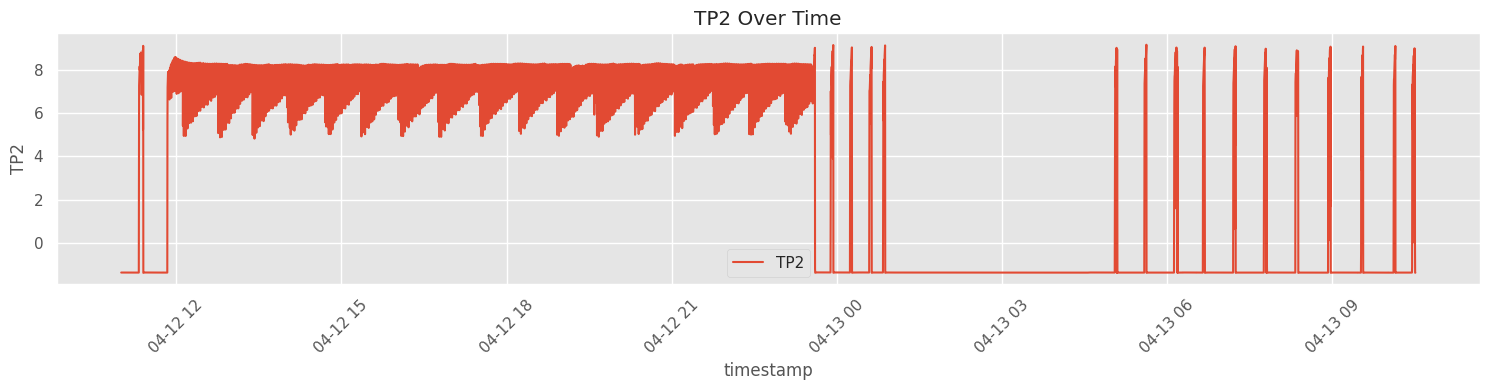

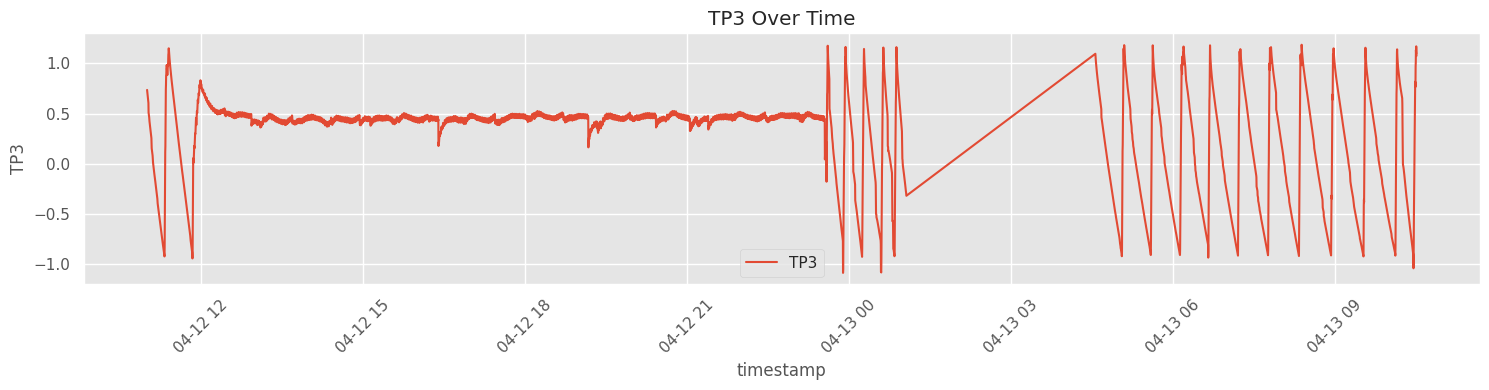

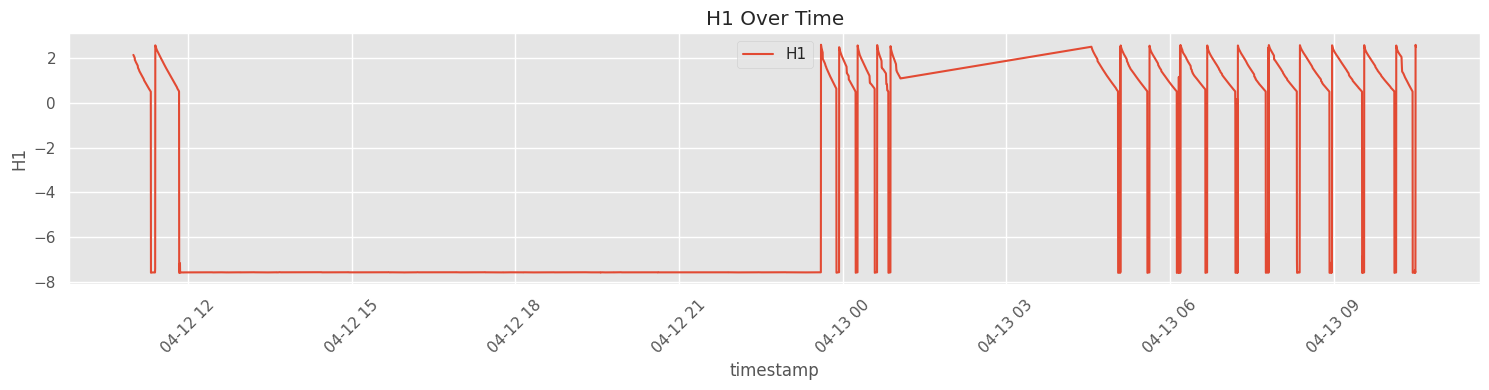

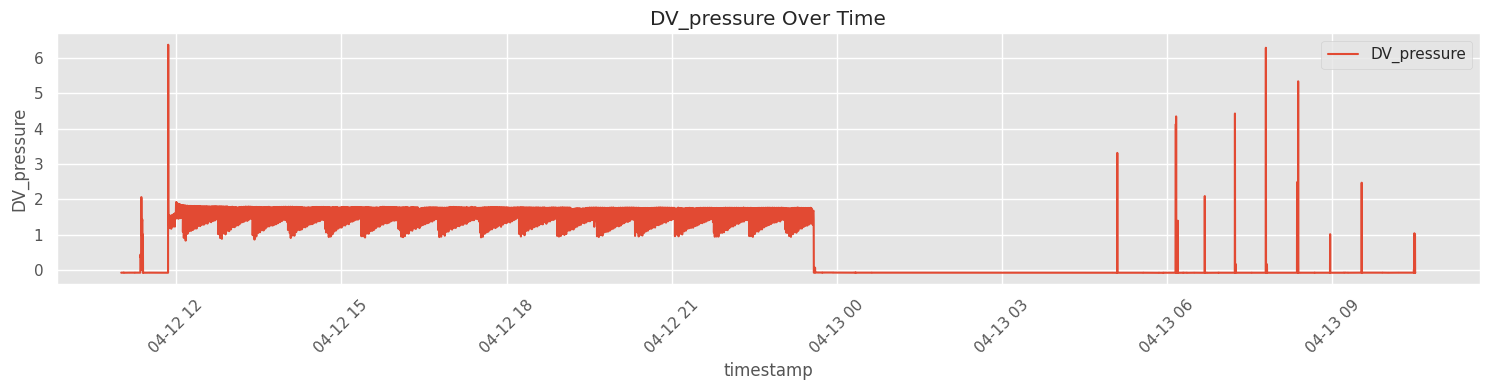

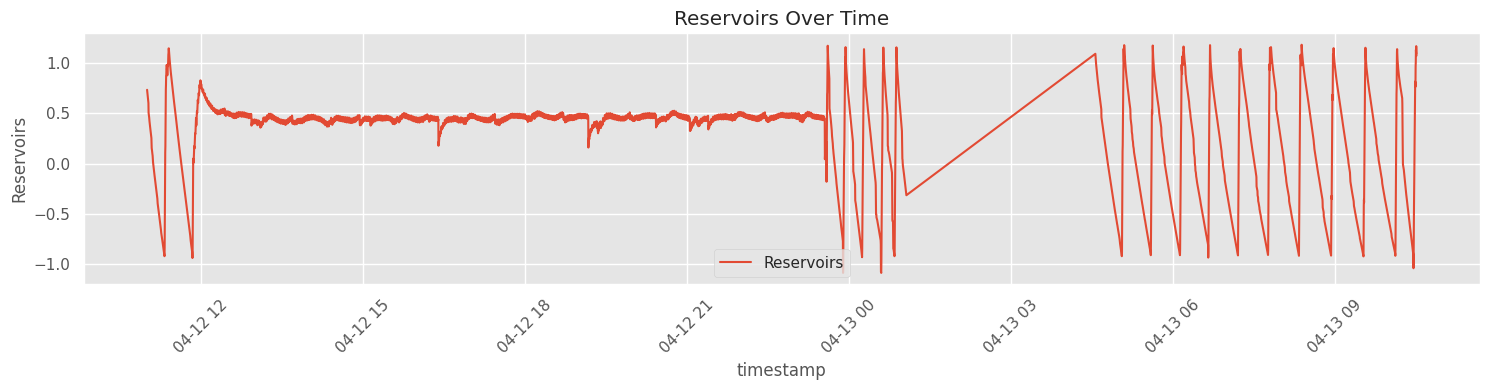

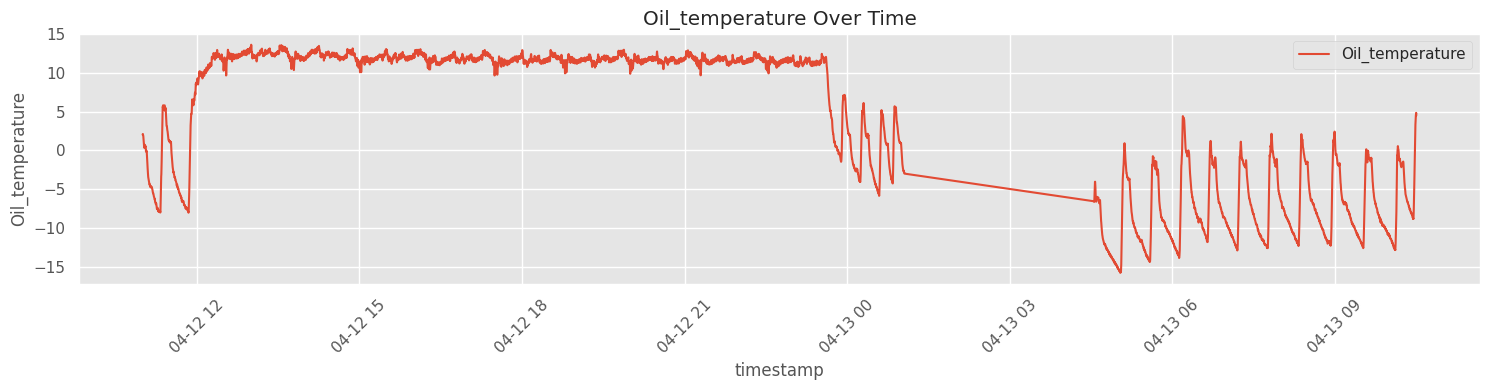

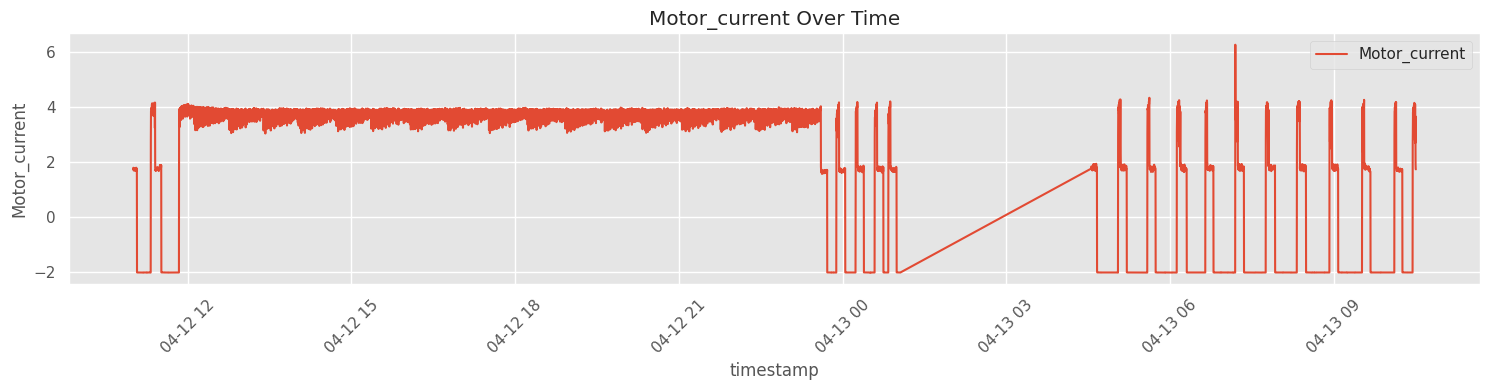

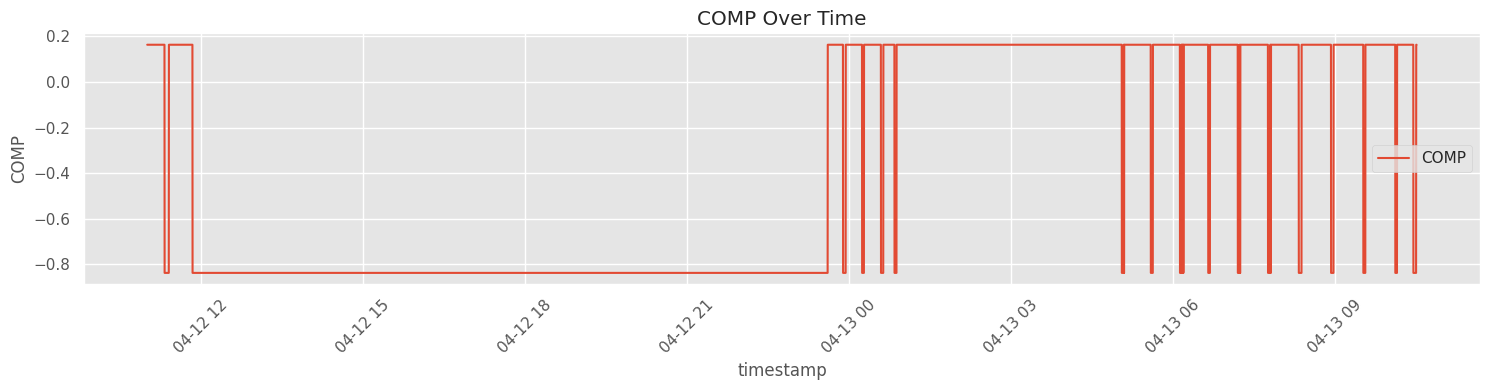

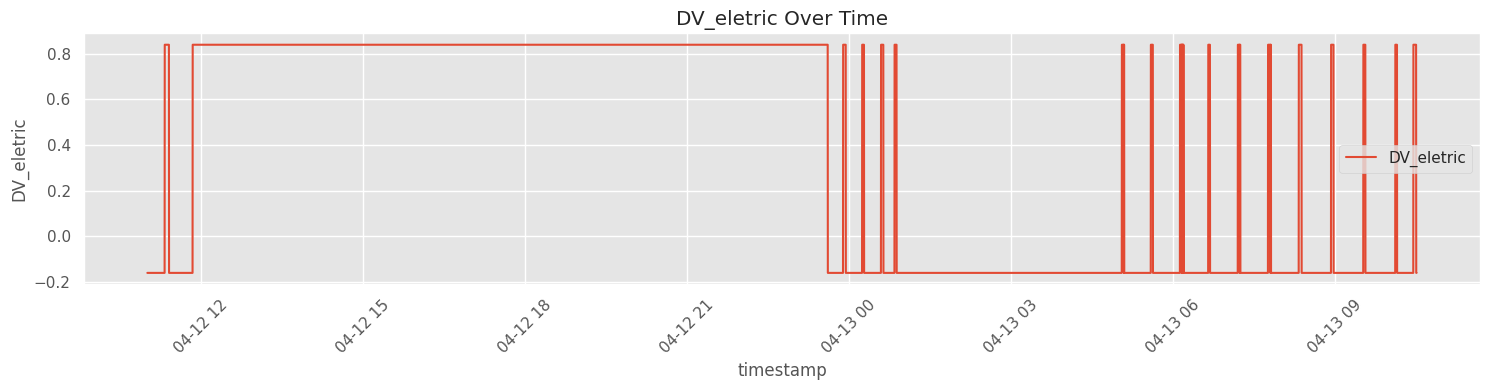

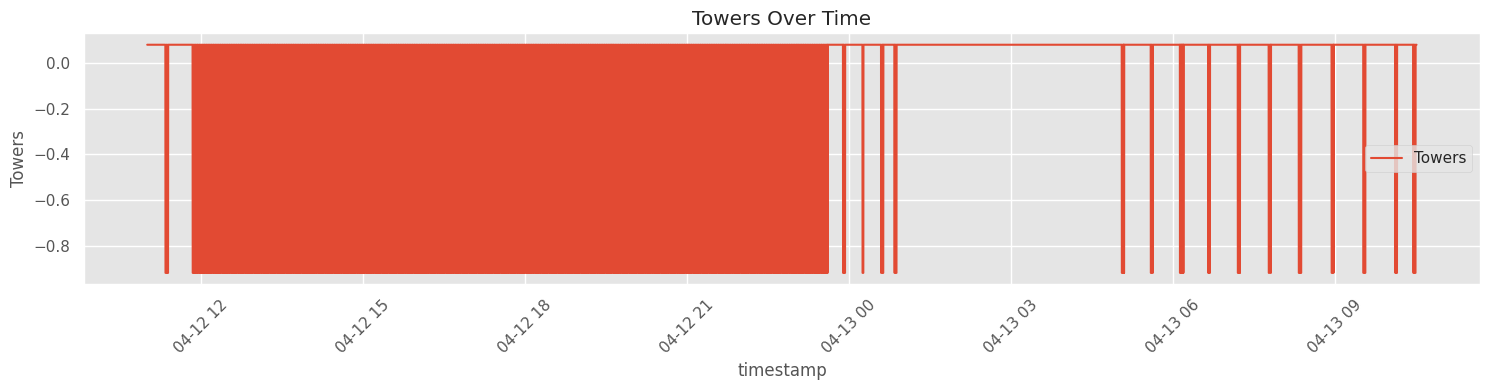

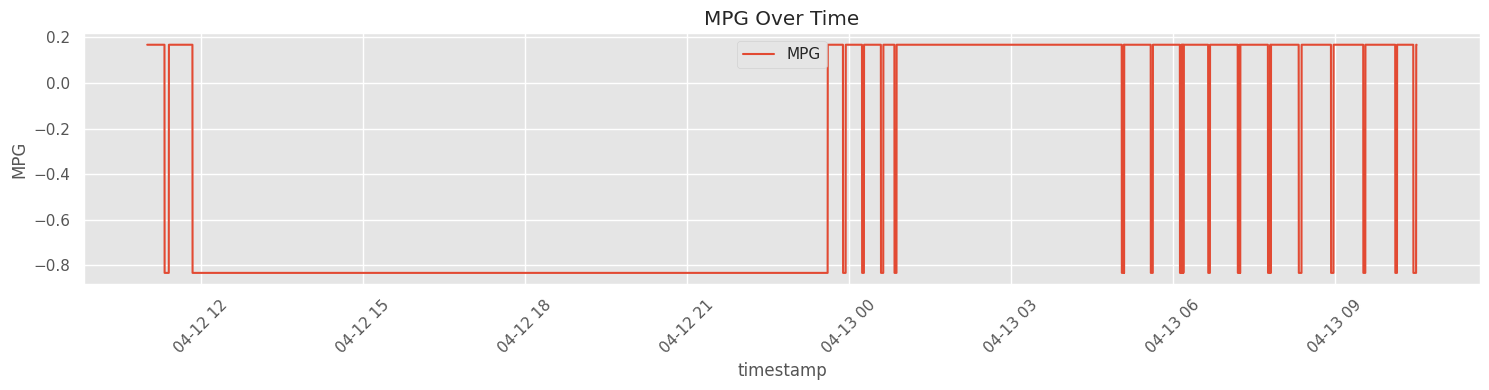

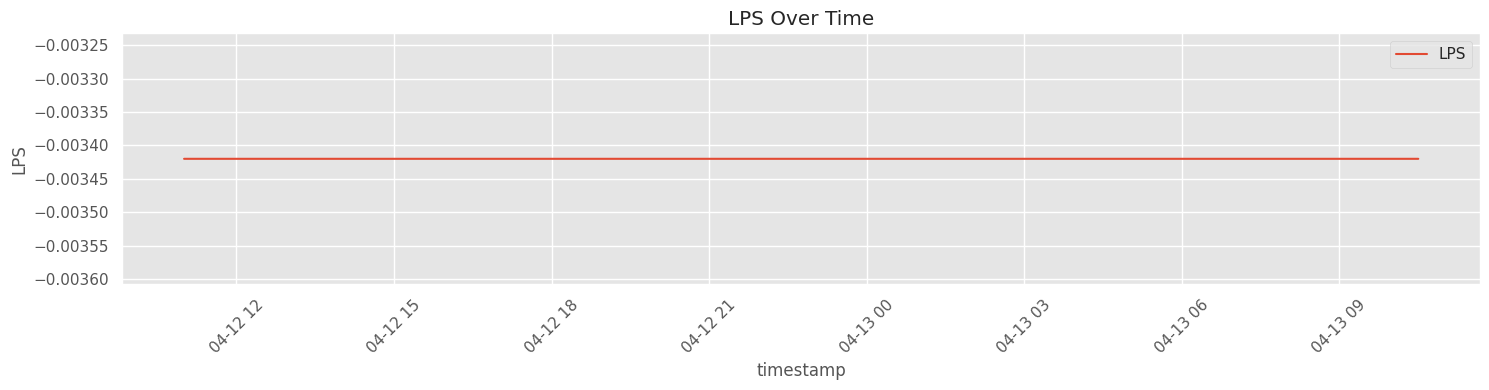

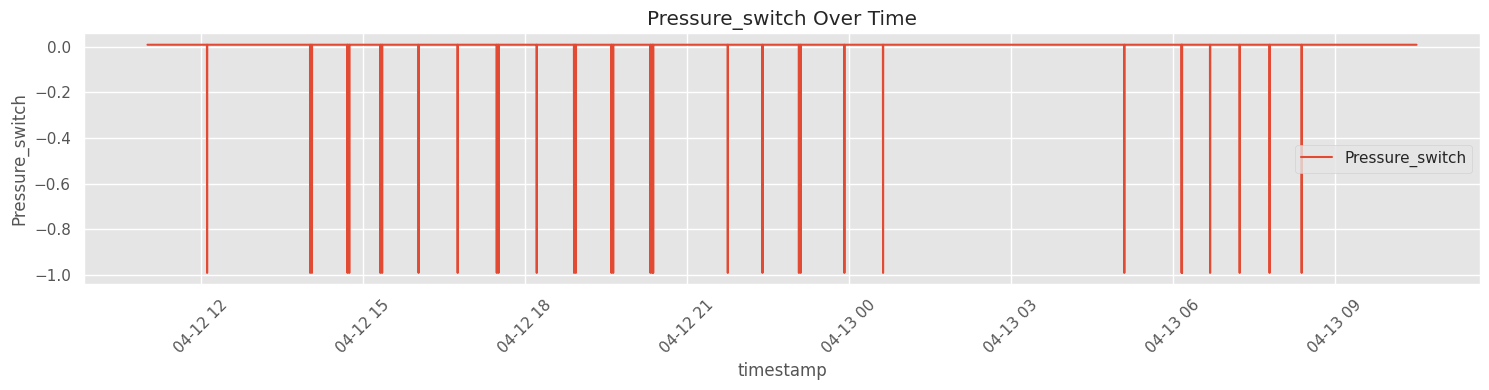

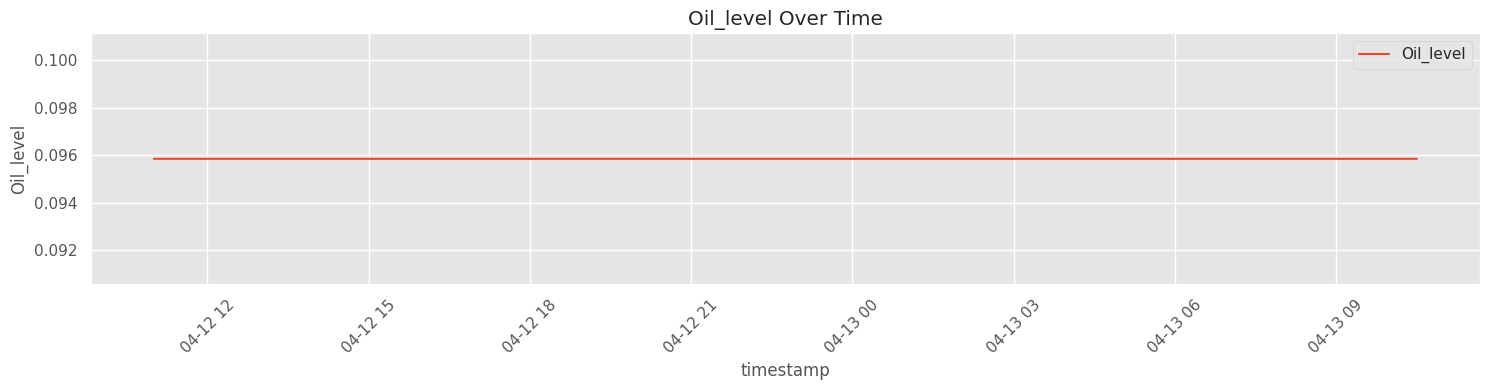

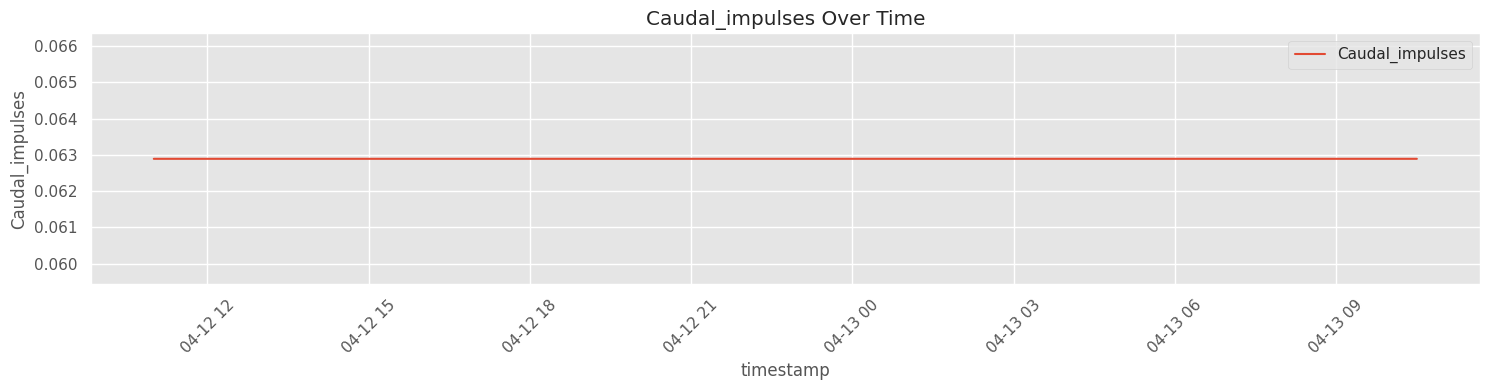

In [34]:
start_date = pl.datetime(2020, 4, 12, 11)
end_date = pl.datetime(2020, 4, 13, 11)
for col in data_norm.select(pl.exclude("timestamp")).columns:
    plot_time_series(data_norm, col, start_date, end_date)

- Graficamos los comportamientos de las series temporales en conjunto en el rango temporal en el que se produjo una anomalía en el sistema.

In [35]:
def plot_all_time_series(
    data: pl.DataFrame,
    start_date: datetime.datetime,
    end_date: datetime.datetime,
):
    # Filter the data
    filtered_data = data.filter(
        (pl.col("timestamp") >= start_date) & (pl.col("timestamp") <= end_date)
    )

    plt.figure(figsize=(15, 6))
    for col in data.select(pl.exclude("timestamp")).columns:
        sns.lineplot(data=filtered_data, x="timestamp", y=col, label=col)
        plt.title("All Variables Over Time")
        plt.xticks(rotation=45)
        plt.tight_layout()
    plt.show()

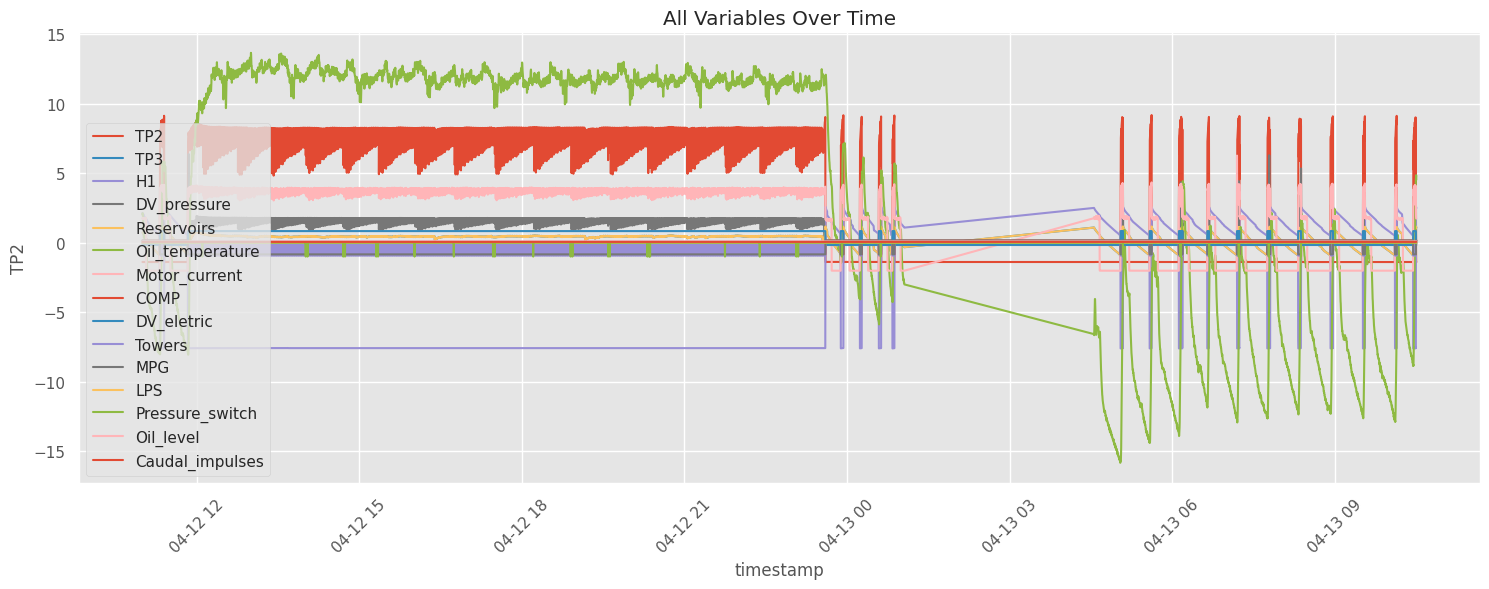

In [36]:
plot_all_time_series(data_norm, start_date, end_date)

- Si mostramos otro rango temporal, podremos observar el comportamiento esperado de cada variable. De hecho, se podría intuir que son series de naturaleza **estacionaria**.
- Una serie estacionaria es una secuencia de datos temporales cuyas propiedades estadísticas, como la media, la varianza y la autocorrelación, son constantes a lo largo del tiempo. Esto significa que su comportamiento no cambia dependiendo del momento en el que se analice, lo que facilita su modelado y predicción.

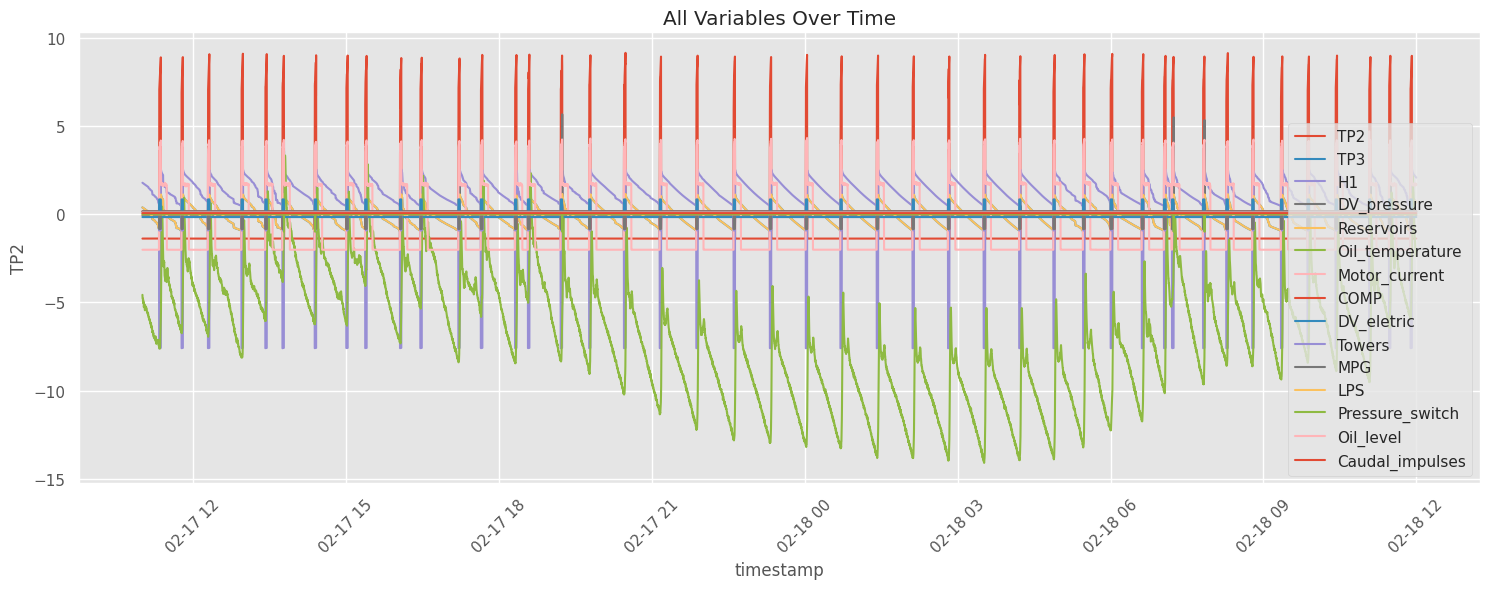

In [37]:
start_date = pl.datetime(2020, 2, 17, 11)
end_date = pl.datetime(2020, 2, 18, 12)
plot_all_time_series(data_norm, start_date, end_date)

# Tests
- Aplicamos tests a las series temporales pare saber si son estacionarias. Si el valor crítico es mayor que el estadístico del test, podemos decir que no son estacionarias.
- La prueba de *Dickey-Fuller* Aumentada (ADF). La prueba ADF es un test estadístico que evalúa si una serie tiene una raíz unitaria, lo cual indicaría que no es estacionaria.

In [38]:
# Create time series for all columns except "timestamp"
time_series_dict = {}

for column in data_norm.columns:
    if column != "timestamp":
        ts = data_norm.select(["timestamp", column])
        ts = ts.set_sorted("timestamp")
        ts = ts.drop(pl.col("timestamp"))
        time_series_dict[column] = ts.to_numpy().flatten()

In [39]:
def check_adfuller(ts, sample_size=1000):
    if len(ts) > sample_size:
        start_idx = np.random.randint(0, len(ts) - sample_size + 1)
        ts_sample = ts[start_idx : start_idx + sample_size]
    else:
        ts_sample = ts

    if len(np.unique(ts_sample)) == 1:
        return {
            "Test Statistic": None,
            "p-value": None,
            "Critical Values": None,
            "Stationary": "Constant series",
        }
    else:
        result = adfuller(ts_sample, autolag="AIC")
        stationary = result[1] < 0.05 and result[0] < result[4]["5%"]
        return {
            "Test Statistic": result[0],
            "p-value": result[1],
            "Critical Values": result[4],
            "Stationary": "Yes" if stationary else "No",
        }

- Ya que tenemos muchos datos, hacer la prueba de adfuller con todos en cada columna no es viable. Por tanto, de manera aleatoria se escogen muestras de tramos aleatorios de cada variable. De esta manera podemos evaluar si la serie es estacionaria en gran parte de sus tramos y deducir si la serie completa es estacionaria.

In [40]:
repetitions = 10
sample_size = 1000

results = []

for repetition in range(1, repetitions + 1):
    print(f"\n### Repetition {repetition} ###")
    for column in data_norm.columns:
        if column != "timestamp":
            result = check_adfuller(time_series_dict[column], sample_size=sample_size)
            result["Column"] = column
            result["Repetition"] = repetition
            results.append(result)

results_df = pl.DataFrame(results)

print("\n### Results Summary ###")
for column_name in results_df["Column"].unique():
    print(f"\n# ------ {column_name} ------ #")
    column_results = results_df.filter(pl.col("Column") == column_name).to_dicts()
    for row in column_results:
        print(
            f"Repetition {row['Repetition']}: "
            f"Test Statistic = {row['Test Statistic']}, "
            f"p-value = {row['p-value']}, "
            f"Stationary = {row['Stationary']}"
        )


### Repetition 1 ###

### Repetition 2 ###

### Repetition 3 ###

### Repetition 4 ###

### Repetition 5 ###

### Repetition 6 ###

### Repetition 7 ###

### Repetition 8 ###

### Repetition 9 ###

### Repetition 10 ###

### Results Summary ###

# ------ H1 ------ #
Repetition 1: Test Statistic = -5.50856060561777, p-value = 1.9960442662233112e-06, Stationary = Yes
Repetition 2: Test Statistic = -6.211110579870949, p-value = 5.5049162847042e-08, Stationary = Yes
Repetition 3: Test Statistic = -5.869660699633181, p-value = 3.2627806565062036e-07, Stationary = Yes
Repetition 4: Test Statistic = -5.04076407764206, p-value = 1.8419454832121145e-05, Stationary = Yes
Repetition 5: Test Statistic = -5.291595543160873, p-value = 5.69947135203627e-06, Stationary = Yes
Repetition 6: Test Statistic = -2.1873293147936064, p-value = 0.2108762828403834, Stationary = No
Repetition 7: Test Statistic = -7.034099459698094, p-value = 6.078876210954526e-10, Stationary = Yes
Repetition 8: Test Statistic =

- Todas las variables parecen estacionarias según el test. Salvo contadas ocasiones (puede que tramos con anomalías) todas las variables parecen ser constantes a lo largo del tiempo.

# Feature Extraction
- Vamos a intentar sacar descriptores de cada variable para transformar un problema de series temporales en uno con características normales.

In [67]:
def extract_time_series_descriptors(
    ts: np.ndarray, window_size: int, step: int = 1
) -> pl.DataFrame:
    descriptors = []

    # Iterate through the time series using a sliding window
    for start in range(0, len(ts) - window_size + 1, step):
        values = ts[start : start + window_size]

        window_descriptors = {
            "mean": values.mean(),
            "std_dev": values.std(),
            "median": np.median(values),
            "variance": values.var(),
            "min": values.min(),
            "max": values.max(),
            "range": values.max() - values.min(),
            "skewness": pl.Series(values).skew(),
            "kurtosis": pl.Series(values).kurtosis(),
        }
        descriptors.append(window_descriptors)

    return pl.DataFrame(descriptors)

In [ ]:
x = extract_time_series_descriptors(time_series_dict["TP2"], 10000)